In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)


Matplotlib is building the font cache; this may take a moment.


In [2]:
data_path = Path("../responses.csv")

df_raw = pd.read_csv(data_path)
df_raw.head()


,Email,Team,Team lead,AI code assistant usage,Claude Code usage level,Coder Usage,Coding activity level,Level,Tenure band,Which team are you a part of?,Name,Where do you primarily work in the tech stack,How frequently do you currently use AI tools/models in your development process?,Which AI tools do you currently use for professional or personal development? (select all that apply),Where do you primarily use AI in your development workflow? (Select all that apply),"On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?","Have you ever written an `agents.md`, modified your `.claude` directory, or added context specifically for agents in other way?",Unnamed: 17,Team.1,"No – know possible, haven’t tried",No – wasn’t aware,Yes – made meaningful difference,Yes – but no impact,Unnamed: 23,Team.2,Architecture / Design,Debugging,Documentation,Other,Reviewing PRs / Code,Writing New Code,Writing Tests / Cases
0,bruno@coder.com,Coconut,marcin@coder.com,Daily,Light,Daily,Writes code regularly,NaN,NaN,Coconut,Bruno Quaresma,Frontend,Daily,"GitHub Copilot, ChatGPT in browser, Claude Cod...","Writing new code, Writing tests and/or test ca...",Very Helpful,Yes -- but I didn't notice much impact,NaN,Coconut,4,0,1,2,NaN,Coconut,3,3,3,1.0,3.0,5.0,7.0
1,mathias@coder.com,Coconut,marcin@coder.com,Daily,NaN,Daily,Writes code regularly,NaN,NaN,Coconut,Mathias Fredriksson,Backend,Daily,"ChatGPT in browser, Claude Code, Other","Writing new code, Writing tests and/or test ca...",Moderately Helpful,Yes -- and it made a meaningful difference,NaN,Customer Solutions,0,0,4,0,NaN,Customer Solutions,4,3,4,1.0,3.0,4.0,2.0
2,cian@coder.com,Coconut,marcin@coder.com,Daily,NaN,Daily,Writes code regularly,NaN,NaN,Coconut,Cian Johnston,Backend,Daily,"GitHub Copilot, Claude Code, Blink","Writing new code, Writing tests and/or test ca...",Moderately Helpful,No -- I know it's possible but haven't taken t...,NaN,Customer Support,2,0,1,1,NaN,Customer Support,0,4,3,2.0,0.0,3.0,2.0
3,sas@coder.com,Coconut,marcin@coder.com,Daily,NaN,Daily,Writes code regularly,NaN,NaN,Coconut,Sas Swart,Backend,Daily,"Cursor, Other","Writing new code, Writing tests and/or test ca...",Extremely Helpful,No -- I know it's possible but haven't taken t...,NaN,Kiwi,1,1,3,0,NaN,Kiwi,0,1,2,1.0,3.0,4.0,3.0
4,susana@coder.com,Coconut,marcin@coder.com,Daily,NaN,Daily,Writes code regularly,NaN,NaN,Coconut,Susana Ferreira,Backend,Several times a week,"ChatGPT in browser, Claude in browser, Claude ...","Reviewing PRs/Code, Writing tests and/or test ...",Moderately Helpful,Yes -- but I didn't notice much impact,NaN,Mango,1,0,2,1,NaN,Mango,2,3,0,2.0,2.0,2.0,1.0


In [3]:
# Basic column cleanup
team_col = df_raw['Team'].fillna(df_raw['Which team are you a part of?'])
workflow_col = df_raw['Where do you primarily use AI in your development workflow? (Select all that apply)']

# Helper to split multi-select responses
def split_multiselect(series):
    return (
        series.fillna('')
        .str.split(',')
        .apply(lambda items: [item.strip() for item in items if item and item.strip()])
    )

workflow_long = (
    df_raw.assign(team=team_col, workflow_areas=split_multiselect(workflow_col))
    .explode('workflow_areas')
    .dropna(subset=['workflow_areas', 'team'])
)

workflow_counts = (
    workflow_long.groupby(['team', 'workflow_areas'])
    .size()
    .reset_index(name='respondent_count')
)

workflow_counts.head()


,team,workflow_areas,respondent_count
0,Banana,Debugging,1
1,Banana,Documentation,1
2,Banana,Reviewing PRs/Code,1
3,Banana,Writing new code,2
4,Banana,Writing tests and/or test case generation,2


/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/1362107254.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


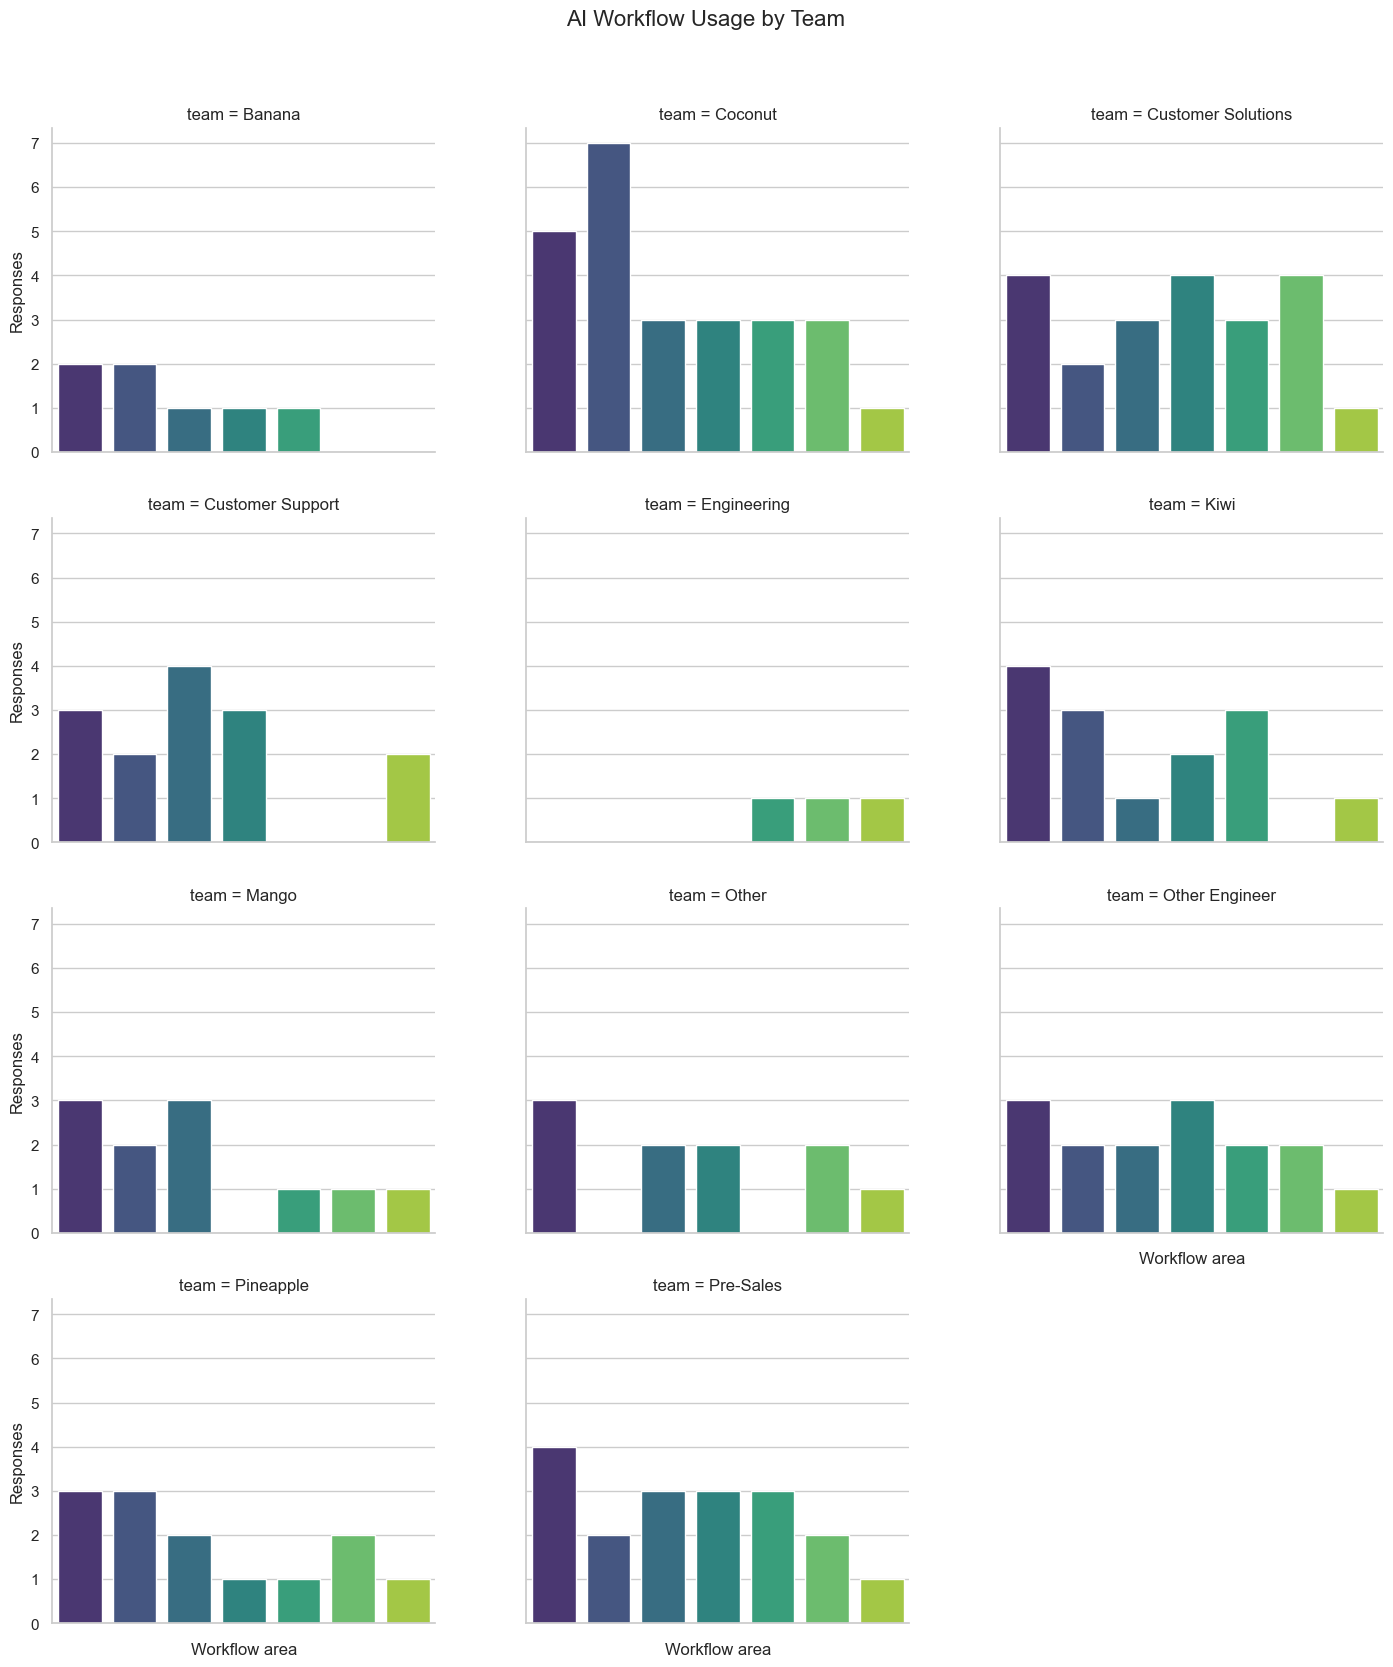

In [4]:
# Plot: AI workflow usage by team
palette = sns.color_palette("viridis", n_colors=workflow_counts['workflow_areas'].nunique())

plot_data = workflow_counts.sort_values(['team', 'respondent_count'], ascending=[True, False])

g = sns.catplot(
    data=plot_data,
    kind='bar',
    x='workflow_areas',
    y='respondent_count',
    col='team',
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette=palette
)

g.set_xticklabels(rotation=30, ha='right')
g.set_axis_labels("Workflow area", "Responses")
g.fig.suptitle("AI Workflow Usage by Team", fontsize=16, y=1.05)
plt.show()


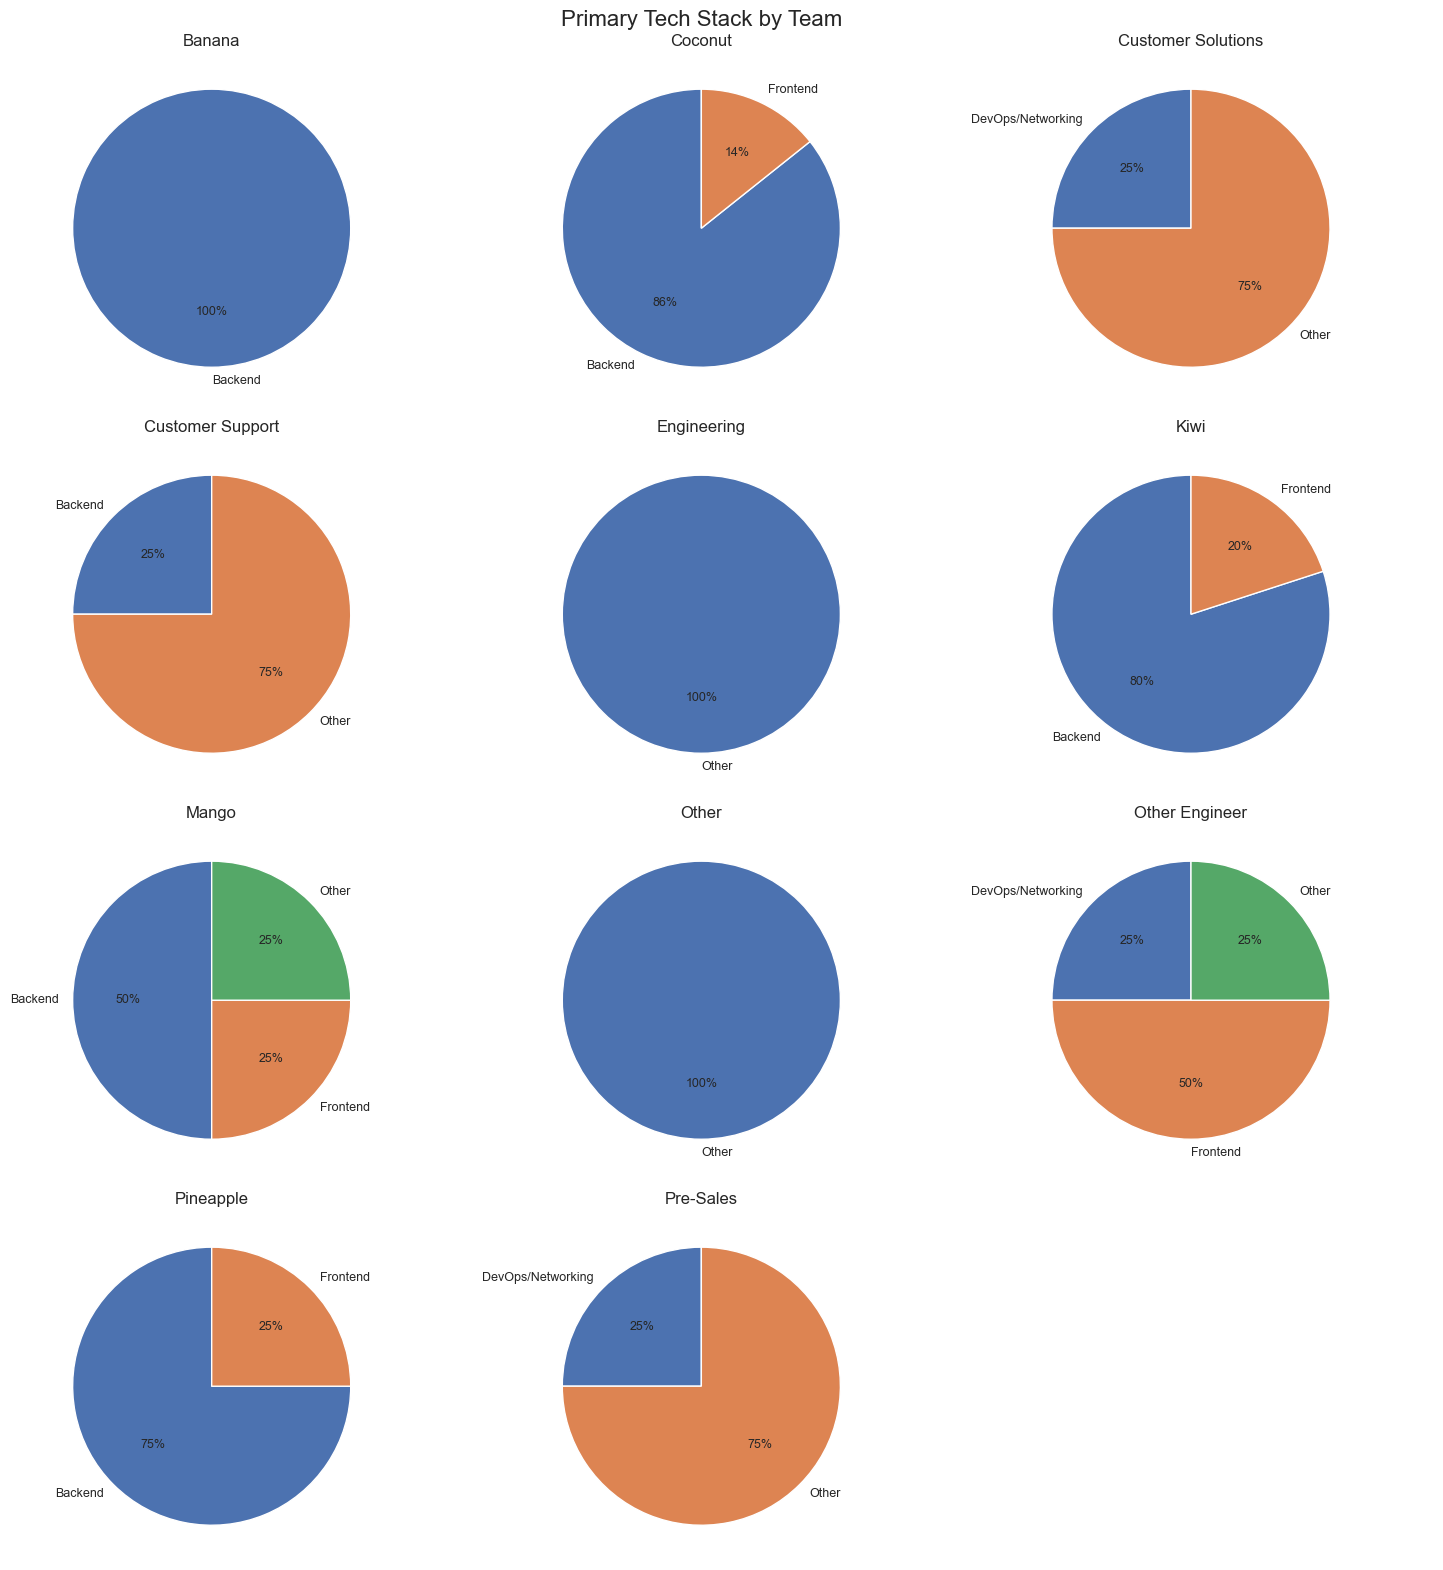

In [5]:
# Pie charts: tech stack distribution by team
tech_stack_col = df_raw['Where do you primarily work in the tech stack'].fillna('Not specified')

tech_counts = (
    df_raw.assign(team=team_col, tech_stack=tech_stack_col)
    .dropna(subset=['team'])
    .groupby(['team', 'tech_stack'])
    .size()
    .reset_index(name='respondent_count')
)

teams = tech_counts['team'].unique()
cols = 3
rows = int(np.ceil(len(teams) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, team in zip(axes, teams):
    team_data = tech_counts[tech_counts['team'] == team]
    ax.pie(
        team_data['respondent_count'],
        labels=team_data['tech_stack'],
        autopct='%1.0f%%',
        startangle=90,
        textprops={'fontsize': 9}
    )
    ax.set_title(f"{team}")

# Hide any unused subplots
for ax in axes[len(teams):]:
    ax.axis('off')

fig.suptitle("Primary Tech Stack by Team", fontsize=16)
plt.tight_layout()
plt.show()


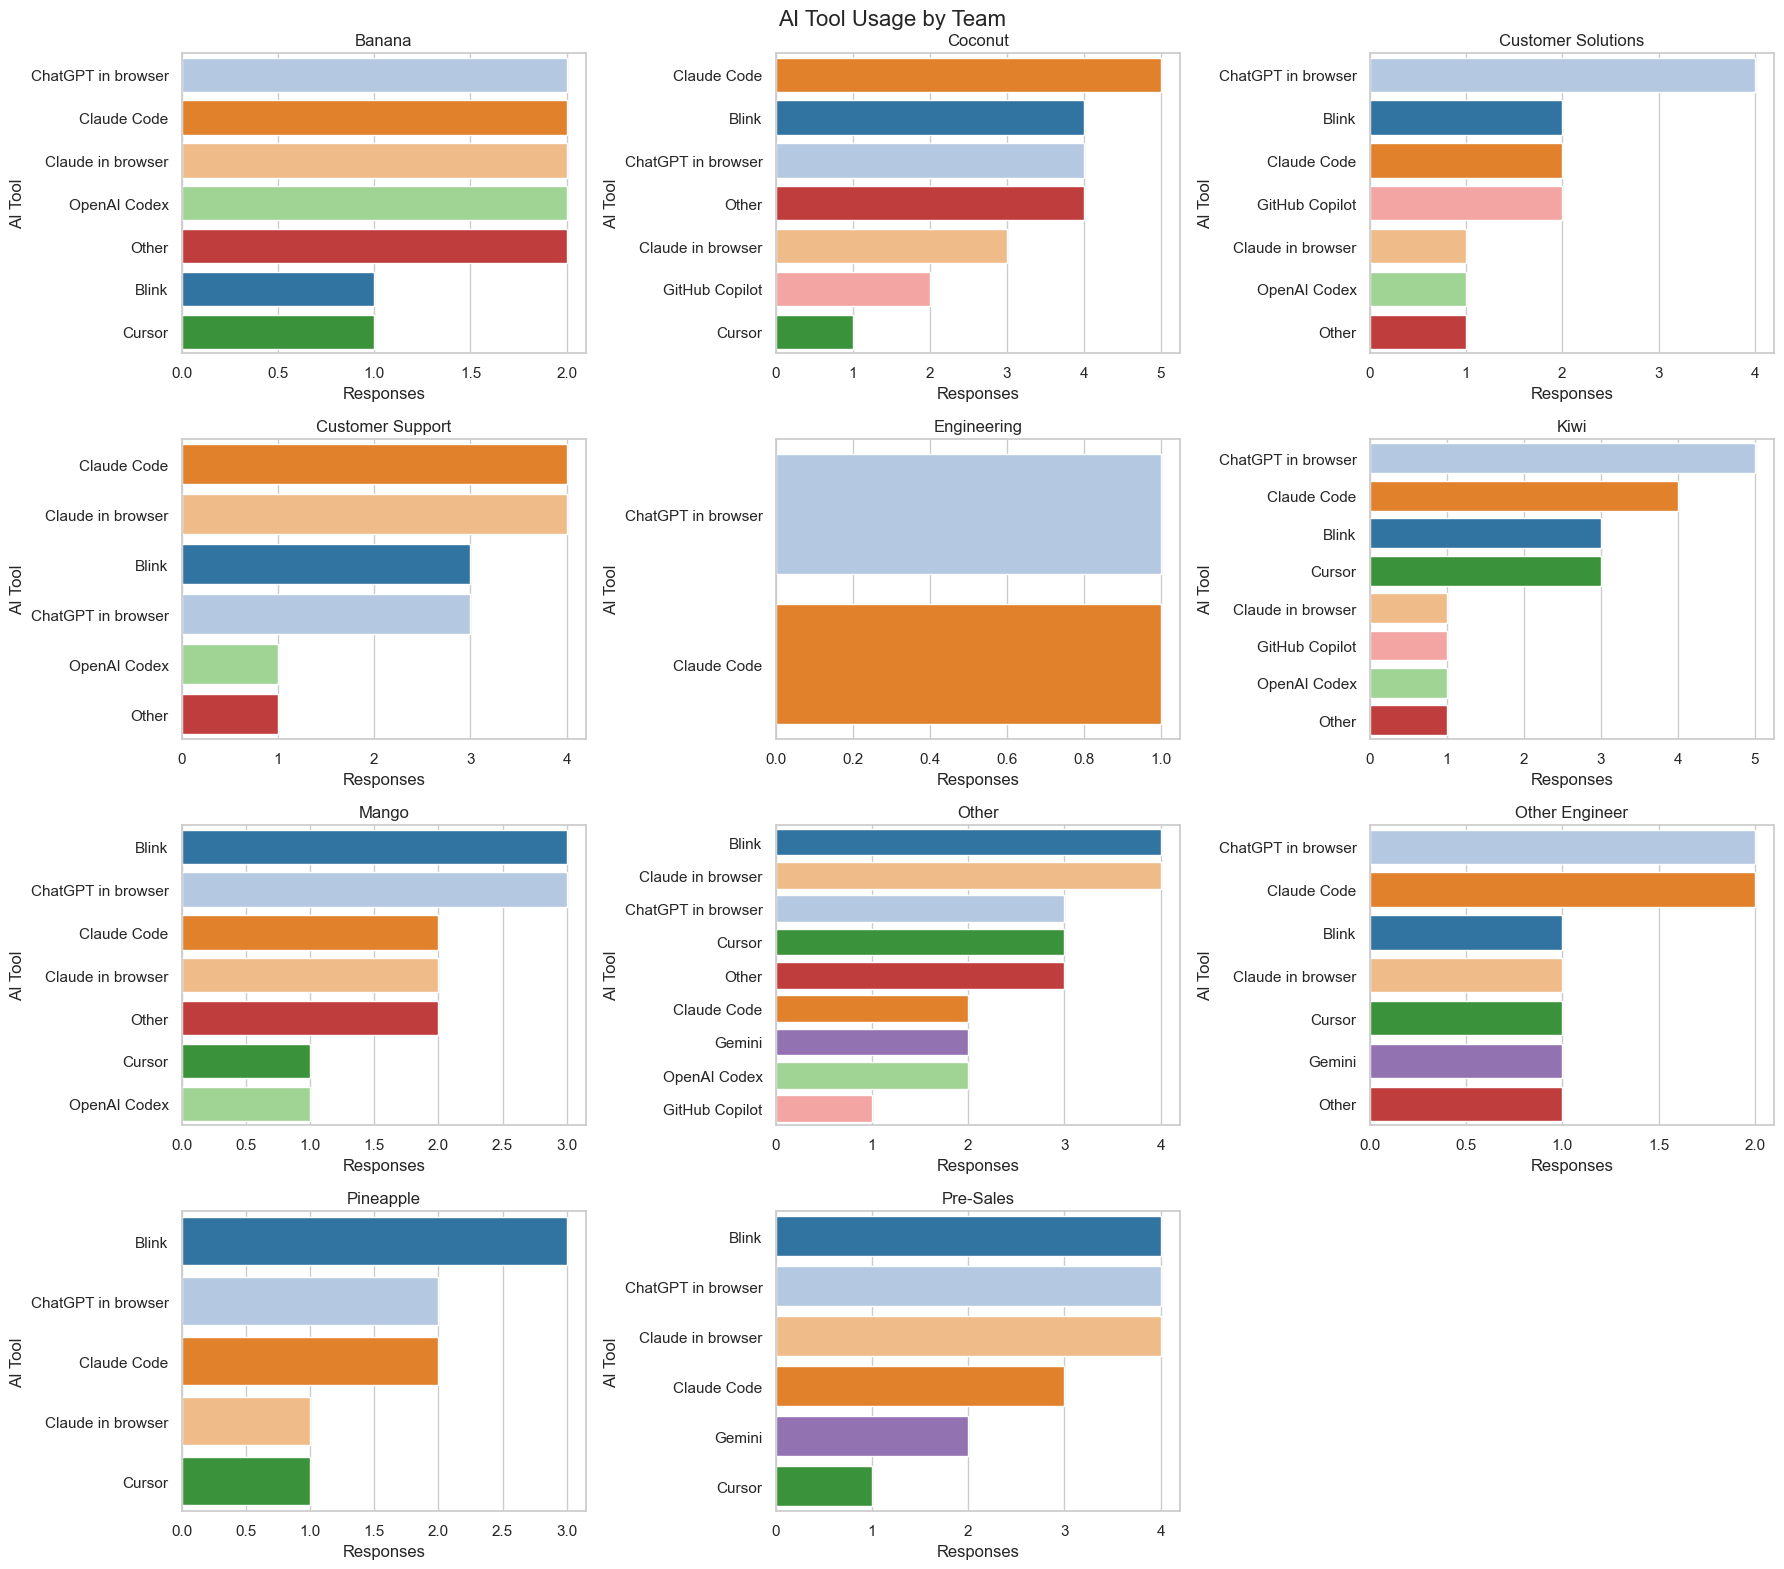

In [7]:
# Bar charts: AI tool usage by team
ai_tools_col = df_raw['Which AI tools do you currently use for professional or personal development? (select all that apply)']

ai_tool_long = (
    df_raw.assign(team=team_col, ai_tools=split_multiselect(ai_tools_col))
    .explode('ai_tools')
    .dropna(subset=['ai_tools', 'team'])
)

ai_tool_counts = (
    ai_tool_long.groupby(['team', 'ai_tools'])
    .size()
    .reset_index(name='respondent_count')
)

palette_tools = dict(
    zip(
        ai_tool_counts['ai_tools'].unique(),
        sns.color_palette('tab20', n_colors=ai_tool_counts['ai_tools'].nunique())
    )
)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for ax, team in zip(axes, teams):
    team_data = ai_tool_counts[ai_tool_counts['team'] == team].sort_values('respondent_count', ascending=False)
    sns.barplot(
        data=team_data,
        x='respondent_count',
        y='ai_tools',
        hue='ai_tools',
        palette=palette_tools,
        dodge=False,
        legend=False,
        ax=ax
    )
    ax.set_title(team)
    ax.set_xlabel('Responses')
    ax.set_ylabel('AI Tool')

for ax in axes[len(teams):]:
    ax.axis('off')

fig.suptitle('AI Tool Usage by Team', fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/2293515952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


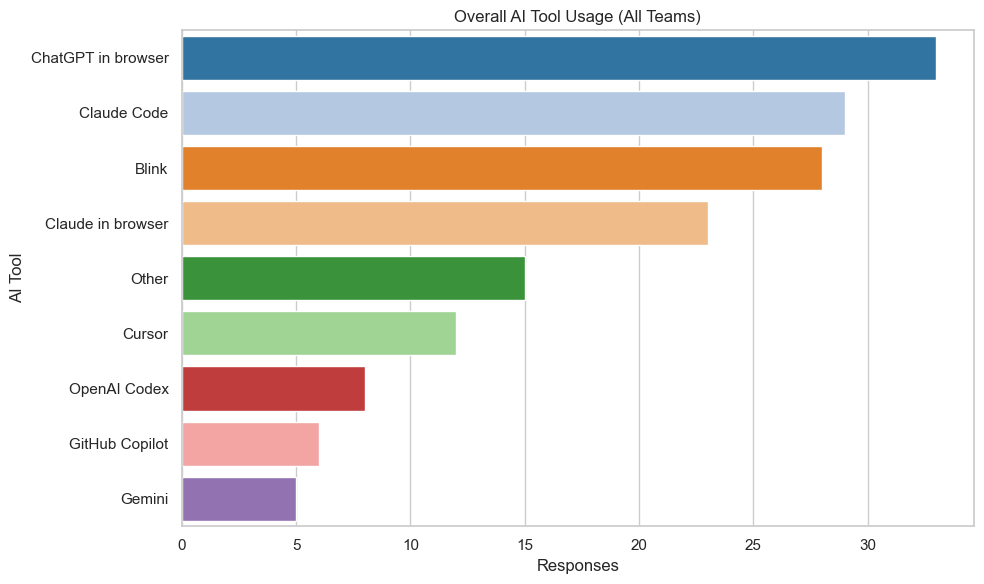

In [8]:
# Overall AI tool usage across all teams
overall_tool_counts = (
    ai_tool_long.groupby('ai_tools')
    .size()
    .reset_index(name='respondent_count')
    .sort_values('respondent_count', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=overall_tool_counts,
    x='respondent_count',
    y='ai_tools',
    palette='tab20'
)
plt.title('Overall AI Tool Usage (All Teams)')
plt.xlabel('Responses')
plt.ylabel('AI Tool')
plt.tight_layout()
plt.show()


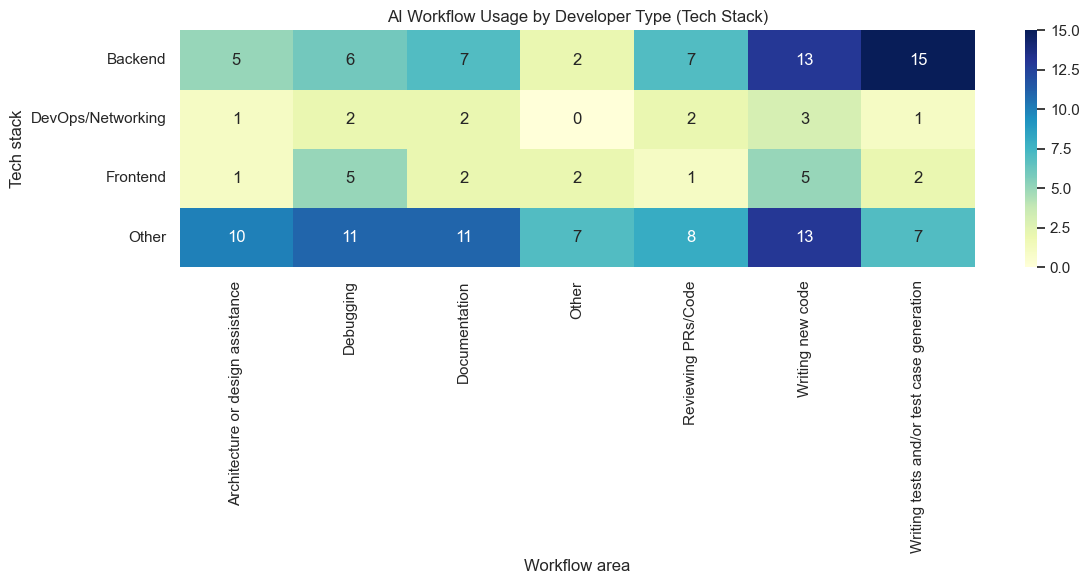

In [12]:
# Heatmap: AI workflow usage by developer type (tech stack)
tech_workflow_long = (
    df_raw.assign(
        tech_stack=tech_stack_col.str.strip(),
        workflow_areas=split_multiselect(workflow_col)
    )
    .explode('workflow_areas')
    .dropna(subset=['workflow_areas', 'tech_stack'])
)

tech_workflow_counts = (
    tech_workflow_long.groupby(['tech_stack', 'workflow_areas'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    tech_workflow_counts,
    annot=True,
    fmt='d',
    cmap='YlGnBu'
)
ax.set_yticklabels(
    [label.get_text().replace(' / ', '\n') for label in ax.get_yticklabels()],
    rotation=0
)
plt.title('AI Workflow Usage by Developer Type (Tech Stack)')
plt.xlabel('Workflow area')
plt.ylabel('Tech stack')
plt.tight_layout()
plt.show()


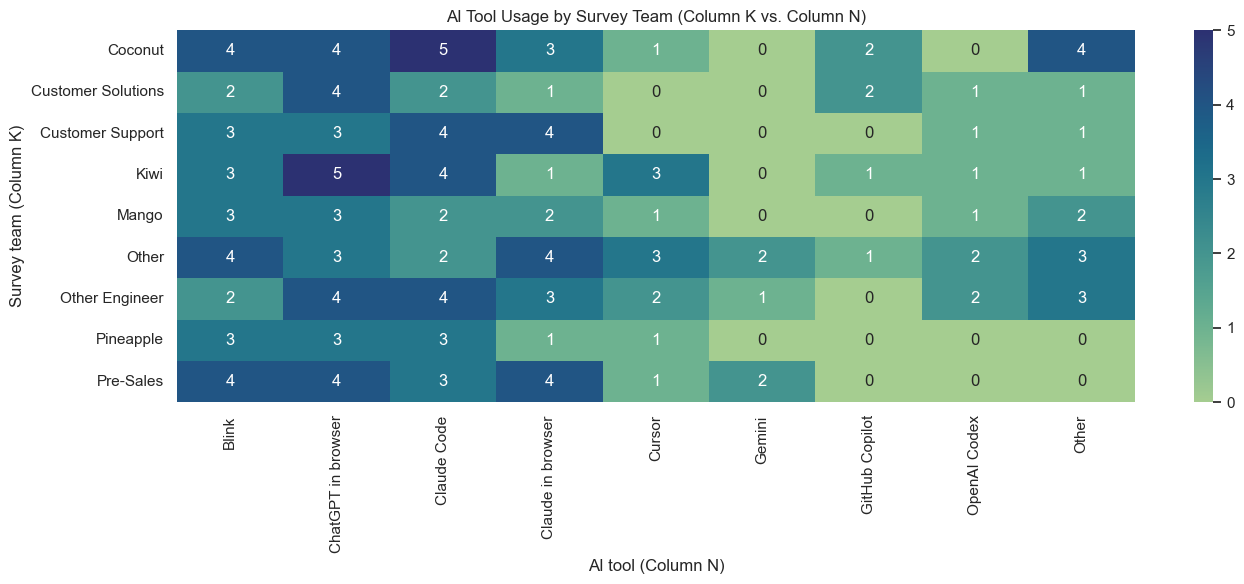

In [13]:
# Heatmap: AI tool usage by survey team (column K)
survey_team_col = df_raw['Which team are you a part of?'].fillna('Not specified')

team_tool_long = (
    df_raw.assign(survey_team=survey_team_col, ai_tools=split_multiselect(ai_tools_col))
    .explode('ai_tools')
    .dropna(subset=['ai_tools', 'survey_team'])
)

team_tool_counts = (
    team_tool_long.groupby(['survey_team', 'ai_tools'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    team_tool_counts,
    annot=True,
    fmt='d',
    cmap='crest'
)
ax.set_title('AI Tool Usage by Survey Team (Column K vs. Column N)')
ax.set_xlabel('AI tool (Column N)')
ax.set_ylabel('Survey team (Column K)')
plt.tight_layout()
plt.show()


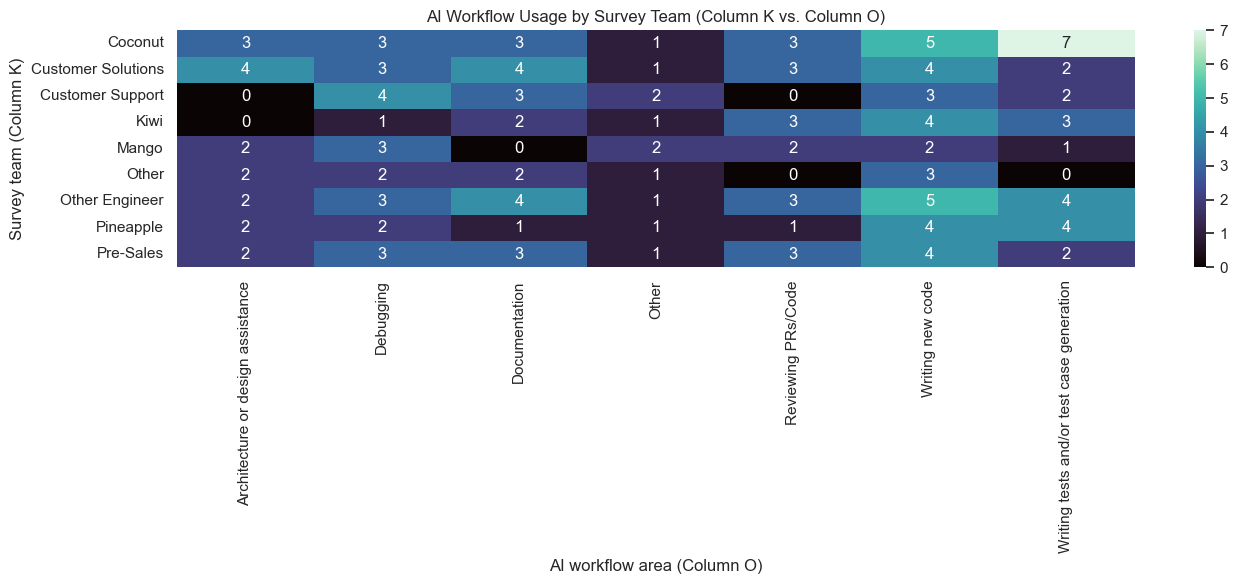

In [14]:
# Heatmap: Survey team (column K) vs. primary AI usage areas (column O)
survey_team_workflow_long = (
    df_raw.assign(
        survey_team=survey_team_col,
        workflow_areas=split_multiselect(workflow_col)
    )
    .explode('workflow_areas')
    .dropna(subset=['survey_team', 'workflow_areas'])
)

survey_team_workflow_counts = (
    survey_team_workflow_long.groupby(['survey_team', 'workflow_areas'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    survey_team_workflow_counts,
    annot=True,
    fmt='d',
    cmap='mako'
)
ax.set_title('AI Workflow Usage by Survey Team (Column K vs. Column O)')
ax.set_xlabel('AI workflow area (Column O)')
ax.set_ylabel('Survey team (Column K)')
plt.tight_layout()
plt.show()


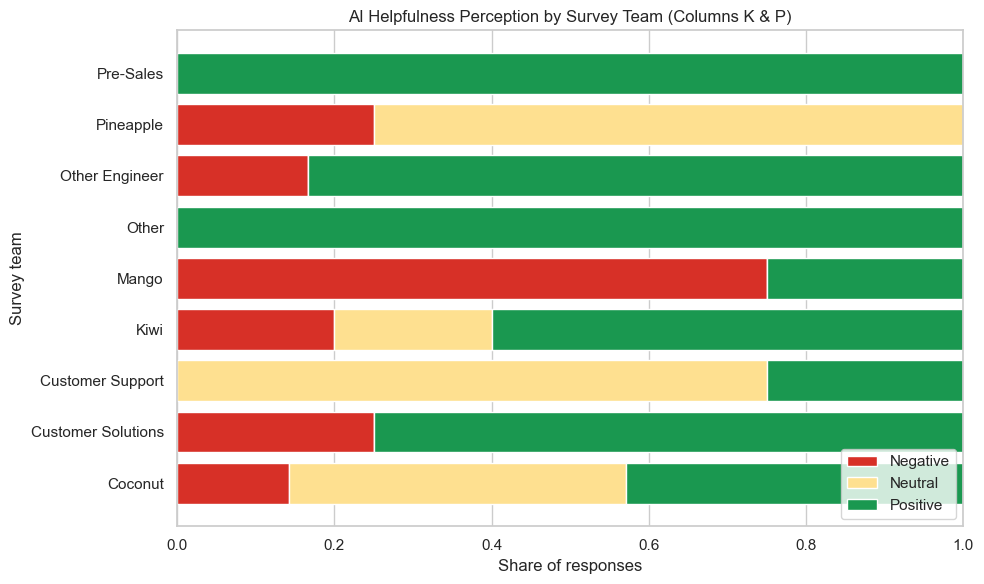

In [16]:
# Diverging bar chart: AI helpfulness ratings by survey team (columns K & P)
helpfulness_col_name = next(
    col for col in df_raw.columns
    if 'how would you rate the overall helpfulness of AI' in col
)

helpfulness_order = [
    'Not at all Helpful',
    'Slightly Helpful',
    'Moderately Helpful',
    'Very Helpful',
    'Extremely Helpful'
]

helpfulness_counts = (
    df_raw.assign(survey_team=survey_team_col, helpfulness=df_raw[helpfulness_col_name])
    .dropna(subset=['survey_team', 'helpfulness'])
    .groupby(['survey_team', 'helpfulness'])
    .size()
    .reset_index(name='respondent_count')
)

helpfulness_pivot = helpfulness_counts.pivot(
    index='survey_team',
    columns='helpfulness',
    values='respondent_count'
).fillna(0)

helpfulness_pivot = helpfulness_pivot.reindex(columns=helpfulness_order, fill_value=0)
helpfulness_pct = helpfulness_pivot.div(helpfulness_pivot.sum(axis=1), axis=0)

positive = helpfulness_pct[['Very Helpful', 'Extremely Helpful']].sum(axis=1)
neutral = helpfulness_pct[['Moderately Helpful']].sum(axis=1)
negative = helpfulness_pct[['Not at all Helpful', 'Slightly Helpful']].sum(axis=1)

helpfulness_summary = pd.DataFrame({
    'positive': positive,
    'neutral': neutral,
    'negative': negative
}).fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(helpfulness_summary.index, helpfulness_summary['negative'], color='#d73027', label='Negative')
ax.barh(helpfulness_summary.index, helpfulness_summary['neutral'], left=helpfulness_summary['negative'], color='#fee090', label='Neutral')
ax.barh(helpfulness_summary.index, helpfulness_summary['positive'], left=helpfulness_summary['negative'] + helpfulness_summary['neutral'], color='#1a9850', label='Positive')

ax.set_title('AI Helpfulness Perception by Survey Team (Columns K & P)')
ax.set_xlabel('Share of responses')
ax.set_ylabel('Survey team')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_13456/2347346647.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  helpfulness_counts_full.groupby('survey_team')


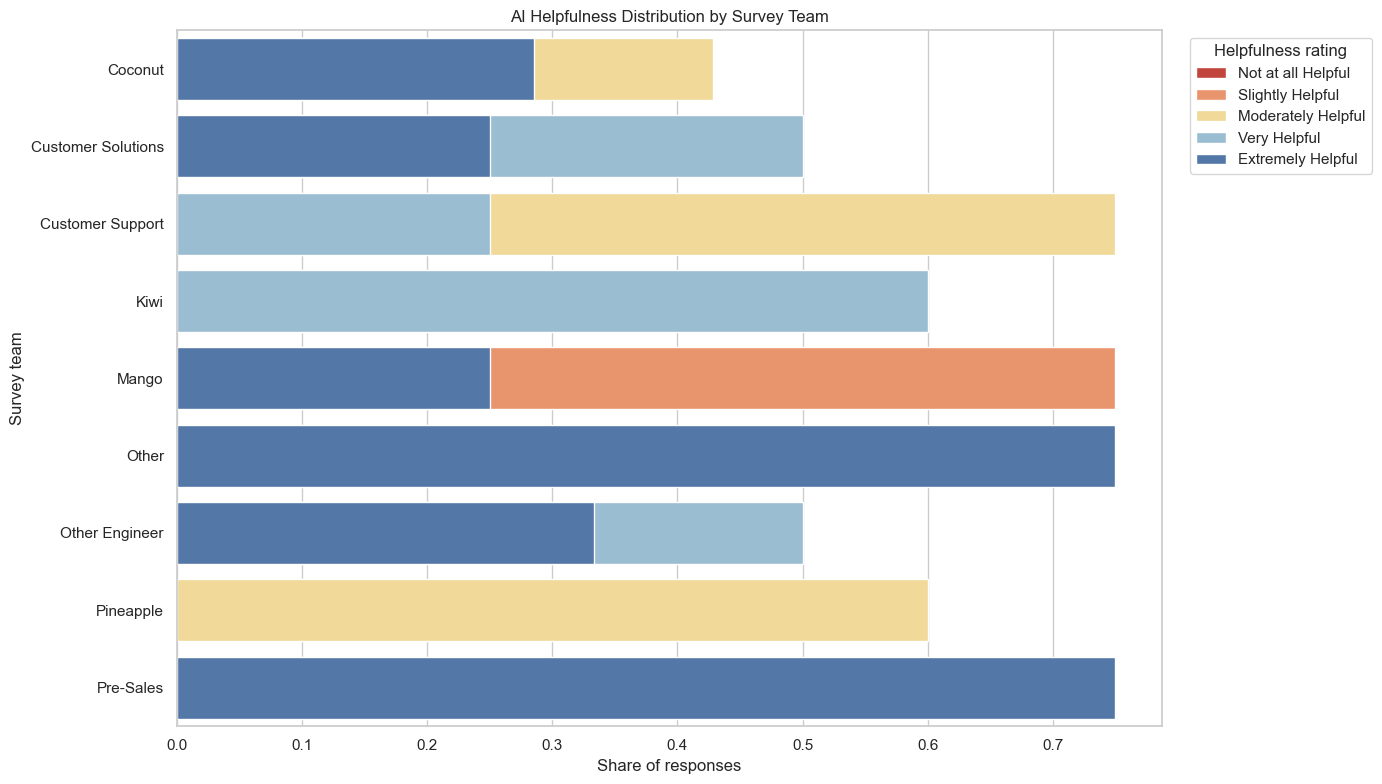

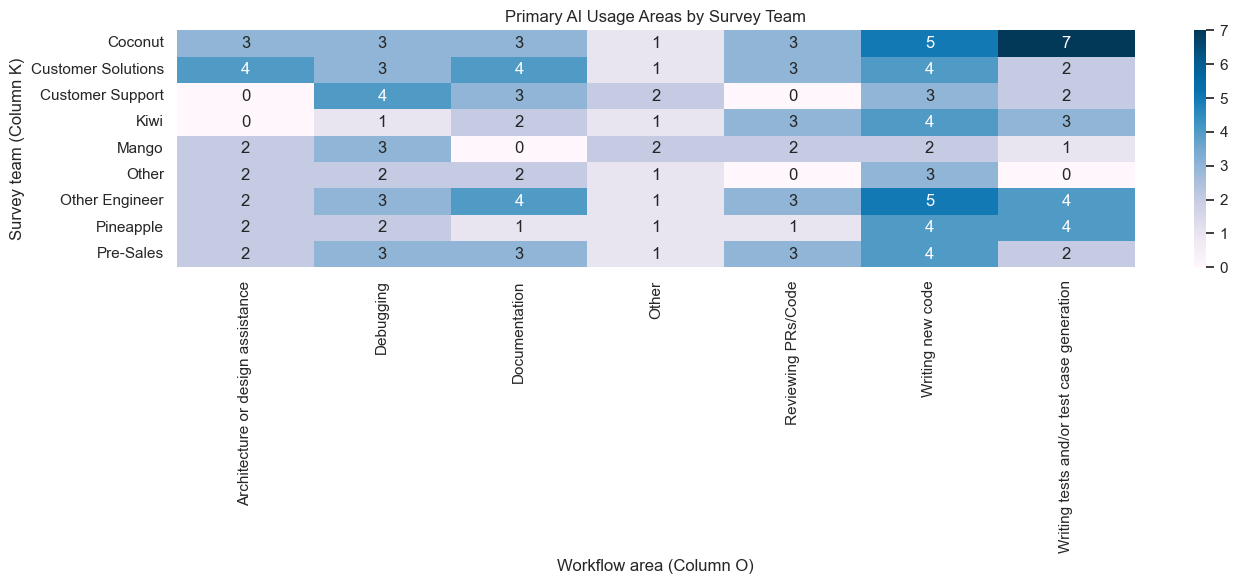

In [17]:
# Combined view: AI helpfulness vs. primary usage by survey team (columns K, P, O)
helpfulness_label_order = helpfulness_order  # from previous cell

helpfulness_counts_full = (
    df_raw.assign(survey_team=survey_team_col, helpfulness=df_raw[helpfulness_col_name])
    .dropna(subset=['survey_team', 'helpfulness'])
    .groupby(['survey_team', 'helpfulness'])
    .size()
    .reset_index(name='count')
)

helpfulness_pct_full = (
    helpfulness_counts_full.groupby('survey_team')
    .apply(lambda group: group.assign(share=group['count'] / group['count'].sum()))
    .reset_index(drop=True)
)

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=helpfulness_pct_full,
    x='share',
    y='survey_team',
    hue='helpfulness',
    order=sorted(helpfulness_pct_full['survey_team'].unique()),
    hue_order=helpfulness_label_order,
    palette=['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4'],
    dodge=False
)
ax.set_title('AI Helpfulness Distribution by Survey Team')
ax.set_xlabel('Share of responses')
ax.set_ylabel('Survey team')
ax.legend(title='Helpfulness rating', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    survey_team_workflow_counts,
    annot=True,
    fmt='d',
    cmap='PuBu'
)
ax.set_title('Primary AI Usage Areas by Survey Team')
ax.set_xlabel('Workflow area (Column O)')
ax.set_ylabel('Survey team (Column K)')
plt.tight_layout()
plt.show()
